In [8]:
##Importing Libraries

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

2022-10-03 13:17:04.555842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
#Gettting Data : Apple Stock Price

df = web.DataReader('AAPL', data_source = 'yahoo', start ='2012-01-01', end = '2022-08-01')

In [15]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.540045
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.607439
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.747403
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.880667
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.860235
...,...,...,...,...,...,...
2022-07-26,153.089996,150.800003,152.259995,151.600006,55138700.0,151.389725
2022-07-27,157.330002,152.160004,152.580002,156.789993,78620700.0,156.572510
2022-07-28,157.639999,154.410004,156.979996,157.350006,81378700.0,157.131744


In [16]:
df.shape

(2662, 6)

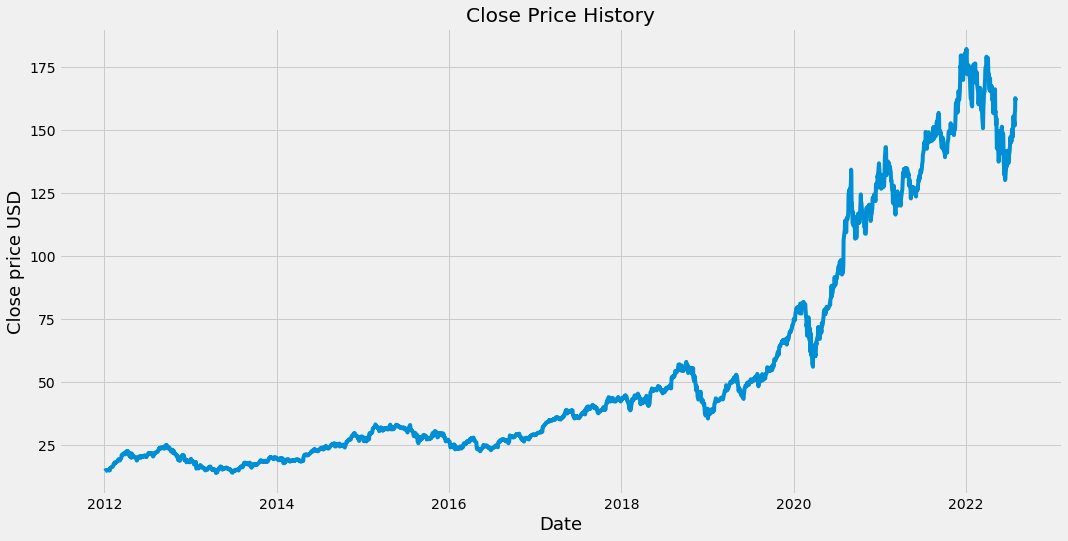

In [22]:
# Visualizing the data

plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel ('Date',fontsize=18)
plt.ylabel ('Close price USD',fontsize=18)
plt.show() 

In [28]:
#Cleaning the data

data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)* .8)
training_data_len


2130

In [26]:
#Scaling the Data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00439887],
       [0.00486851],
       [0.00584391],
       ...,
       [0.85326894],
       [0.88397173],
       [0.87802157]])

In [ ]:
#Preprocessing the data

train_data = scaled_data[0:training_data_len, : ]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

In [35]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [40]:
#Reshaping the data as LSTM requires 3 features.

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(2070, 60, 1)

In [41]:
#Model parameteres 

model = Sequential()
model.add(LSTM(50, return_sequences =True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences =False))
model.add(Dense(25))
model.add(Dense(1))

2022-10-03 13:52:00.958161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [48]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

2070/2070 [==============================] - 49s 24ms/step - loss: 1.4701e-04


In [73]:
#Creating Test data to test the accuracy of the model

test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    

In [74]:
x_test = np.array(x_test)

In [76]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(532, 60, 1)

In [77]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

17/17 [==============================] - 1s 14ms/step


In [78]:
#Prediction accuracy score

rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

6.653809798391242

/var/folders/jq/qrb90qps0yb1czmg7cyqn5z40000gn/T/ipykernel_23101/3784641748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


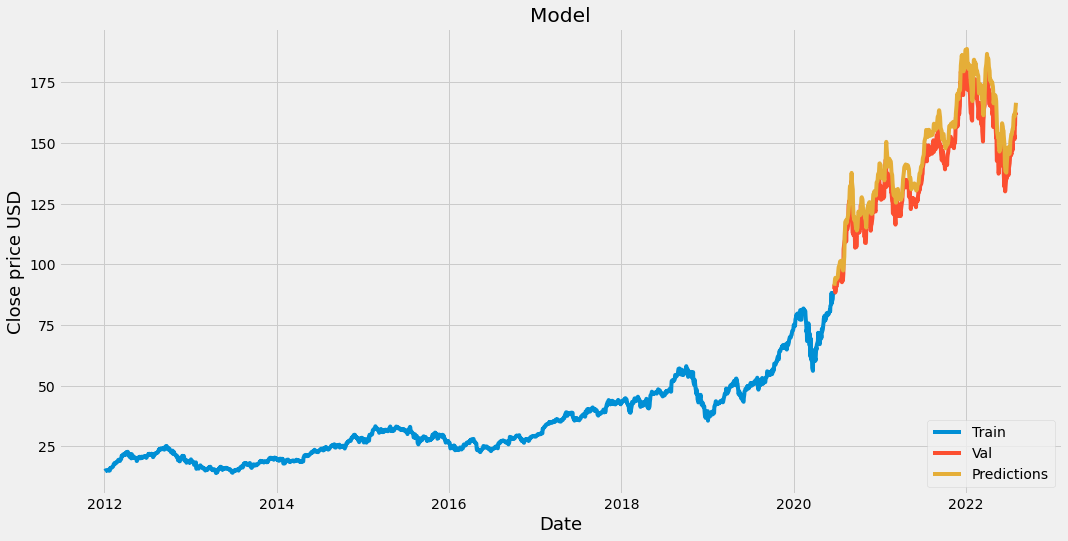

In [79]:
#Visualizing the data to see how well the model is predicting the stock price

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.xlabel ('Date',fontsize=18)
plt.ylabel ('Close price USD',fontsize=18)
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show() 

In [80]:
valid

,Close,Predictions
Date,,
2020-06-22,89.717499,91.161285
2020-06-23,91.632500,91.902733
2020-06-24,90.014999,93.263199
2020-06-25,91.209999,93.854149
2020-06-26,88.407501,94.425583
...,...,...
2022-07-26,151.600006,161.949524
2022-07-27,156.789993,161.030640
2022-07-28,157.350006,162.082169


In [90]:
#Testing model accuracy by selecting a random date and predicting the stock price
apple_quote = web.DataReader('AAPL', data_source='yahoo', start = '2012-01-01', end = '2022-09-01')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 29ms/step
[[165.70581]]


In [92]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start = '2022-09-02', end = '2022-09-02')
print(apple_quote2['Close'])

Date
2022-09-01    157.960007
2022-09-02    155.809998
Name: Close, dtype: float64
